<a href="https://colab.research.google.com/github/HANE48/colab_Deep_learining/blob/main/BERT_learning_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

환경 설정

In [ ]:
!pip install -qqq seaborn # for evaluation visualization
!pip install -qqq wandb   # for logging
!pip install -qqq datasets # huggingface's lib.
!pip install -qqq transformers==4.39.2
!pip install -qqq accelerate==0.28.0
!pip install -qqq shortuuid

!pip install -U accelerate
!pip install tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import torch
import random
import os

# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

데이터셋 로드

In [ ]:
dataset = load_dataset("ag_news")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [ ]:
from pprint import pprint # Using Python's pprint (pretty-print) library to prevent long horizontal output and make the data more readable

print(type(dataset)) # Data type
print(dataset) # Data structure and count
print("\n"*2+ "Train dataset:")
pprint(dataset["train"][1000]) # Print to check the content of train data

# Explanation of labels - 4 classes # https://huggingface.co/datasets/ag_news
# 1 class: World news
# 2 class: Sports news
# 3 class: Business news
# 4 class: Science/Technology news

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


Train dataset:
{'label': 3,
 'text': 'European Union Extends Microsoft-Time Warner Review BRUSSELS, '
         'Belgium (AP) -- European antitrust regulators said Monday they have '
         'extended their review of a deal between Microsoft Corp. (MSFT) and '
         'Time Warner Inc...'}


토크나이저 초기화 및 데이터 전처리

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Data Collator

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

훈련하기

1.모델 정의

In [ ]:
model = BertForSequenceClassification\
        .from_pretrained('bert-base-uncased', num_labels=4)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2. 훈련 인자 정의

훈련 인자는 에포크 수, 배치 크기, 학습률 조정 및 로그와 출력을 저장할 위치와 같은 훈련 과정에 대한 다양한 매개변수를 정의합니다.

In [ ]:
training_args = TrainingArguments(
    output_dir='./results-bert-topic-cls',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',

    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    logging_steps=10,
    ## ----
    report_to="tensorboard",
)

3. 평가용 함수 정의

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

4. 훈련  루프

In [ ]:
# Select the first N samples from the tokenized training dataset
subset_train_dataset = tokenized_datasets['train'].select(range(6000)) # 1/2 data for time saving

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=subset_train_dataset,
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.364000,0.338649,0.889474,0.889438,0.889667,0.889474
2,0.272900,0.300294,0.901316,0.900478,0.902395,0.901316
3,0.146700,0.310492,0.906447,0.906201,0.908515,0.906447


TrainOutput(global_step=564, training_loss=0.4434859513813722, metrics={'train_runtime': 1267.1321, 'train_samples_per_second': 14.205, 'train_steps_per_second': 0.445, 'total_flos': 3163210797786624.0, 'train_loss': 0.4434859513813722, 'epoch': 3.0})

5. 모델 저장

In [ ]:
# Specify the directory where you want to save your model
output_dir = './bert-topic-cls'

# Save the model
model.save_pretrained(output_dir)
# Save the tokenizer
tokenizer.save_pretrained(output_dir)

('./bert-topic-cls/tokenizer_config.json',
 './bert-topic-cls/special_tokens_map.json',
 './bert-topic-cls/vocab.txt',
 './bert-topic-cls/added_tokens.json')

평가

In [ ]:
# Evaluate the model
results = trainer.evaluate()

In [ ]:
print( results )

{'eval_loss': 0.3104916214942932, 'eval_accuracy': 0.9064473684210527, 'eval_f1': 0.9062005426924208, 'eval_precision': 0.9085149708994765, 'eval_recall': 0.9064473684210527, 'eval_runtime': 99.714, 'eval_samples_per_second': 76.218, 'eval_steps_per_second': 9.527, 'epoch': 3.0}


confusion matrix

In [ ]:
# Predictions to get the confusion matrix
predictions = trainer.predict(tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=-1)

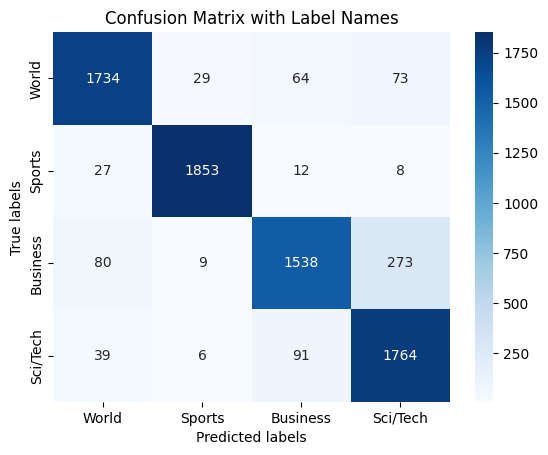

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_map = {
    'LABEL_0': 'World',
    'LABEL_1': 'Sports',
    'LABEL_2': 'Business',
    'LABEL_3': 'Sci/Tech'
}

cm = confusion_matrix(predictions.label_ids, preds)

# label_map to labels
labels = [label_map[f'LABEL_{i}'] for i in range(len(label_map))]

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Label Names')
plt.show()

예측하기

In [ ]:
# Example sentence
sentence = "The stock market is reaching new heights."

# Tokenize the sentence
inputs = tokenizer(sentence, padding=True, truncation=True, max_length=512, return_tensors="pt")

In [ ]:
import torch
# Move inputs to the same device as the model
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Make prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(-1).item()  # Get the predicted class (index)

# Map the prediction index to the class name (if you have a label map)
simple_label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
predicted_label = simple_label_map[predictions]

print(f"Sentence: '{sentence}'")
print(f"Predicted Label: '{predicted_label}'")

Sentence: 'The stock market is reaching new heights.'
Predicted Label: 'Business'


pipeline을 통해 예측

In [ ]:
from transformers import pipeline

# Specify the path to your fine-tuned model or use a pre-trained model from the Hugging Face Model Hub
model_path = './bert-topic-cls'  # Change this to your model's path or a Hugging Face model name

# Load the pipeline for text classification
classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)

In [ ]:
# Example sentences
sentences = [
    "The stock market is reaching new heights.",
    "The new sports car has been unveiled at the auto show.",
    "The tech company announced its latest gadget yesterday."
]

# Make predictions
predictions = classifier(sentences)

# Print the predictions using the label map
for sentence, prediction in zip(sentences, predictions):
    # Map the predicted label to the actual class name
    class_name = label_map[prediction['label']]
    print(f"Sentence: '{sentence}'")
    print(f"Predicted Label: '{class_name}' with score {prediction['score']:.4f}\n")

Sentence: 'The stock market is reaching new heights.'
Predicted Label: 'Business' with score 0.9829

Sentence: 'The new sports car has been unveiled at the auto show.'
Predicted Label: 'World' with score 0.6967

Sentence: 'The tech company announced its latest gadget yesterday.'
Predicted Label: 'Sci/Tech' with score 0.9329

